# DS340W Final Code with Novelty Implementation

### By: Kush Lalwani, Trevor Bunch

The Jupyter Notebook consists of our final code implementation. This includes a redesign of our parent paper's idea of predicting fantasy football player ranks, but this also contains our novelty innovation implementation of predicting rookies.

### Table of Content for Jupyter Notebook

#### Part 1: Model and Feature Setup
1. Packages
2. Model Making with Hyperparamter Tuning
3. Feature Importance Function
4. Helper Functions for Predictions
5. Graph Functions

#### Part 2: Redesign of Parent Paper Code Ideas
1. Data Wrangling for NFL Player Fantasy Football Prediction
2. QB Model Tuning and Prediction
2. RB Model Tuning and Prediction
3. WR Model Tuning and Prediction
4. TE Model Tuning and Prediction
5. Combined Positional Predicitons

#### Part 3: Novelty Implementation
1. Data Wrangling for NFL Rookie Fantasy Football Prediction
2. Rookie QB Model Tuning and Prediction
2. Rookie RB Model Tuning and Prediction
3. Rookie WR Model Tuning and Prediction
4. Rookie TE Model Tuning and Prediction
5. Combined Rookie Positional Predicitons

## Part 1: Model and Feature Setup

### Packages

In [3]:
#loading important packages that will be used throughout
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

def rmse_score(y_true, y_pred): #made an RMSE scorer due to issue with package and ease of implementation
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

rmse_scorer = make_scorer(rmse_score, greater_is_better = False)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Model Making with Hyperparamter Tuning

In [4]:
#making a model pipeline for easier implementation of our models on the data later on
#5 models chosen outlined in our paper

model_pipeline = {

    "Random Forest": ( #random forest used in our parent paper
        RandomForestRegressor(n_jobs = 1, random_state = 4),
        {
            "model__n_estimators": [200, 350, 500], #looking at common rf hyperparamters for future grid search
            "model__max_depth": [5, 10, 20],
            "model__min_samples_split": [2, 5, 10],
        }, 
    ), 

    "Lasso": ( #lasso is a good regressor in general
       Lasso(max_iter = 50000, random_state = 4), #max_iter high due to convergence warnings
        {
            "model__alpha": [.01, .1, 1, 10] #looking at common lasso hyperparamter for future grid search
        }, 
    ), 

    "Neural Network": ( #nn used in one of research papers
        MLPRegressor(max_iter = 4000, early_stopping = True, random_state = 4), #max_iter high due to convergence warnings
        {
            "model__hidden_layer_sizes": [(64, ), (128, ), (64, 32), (128, 64)], #looking at common nn hyperparamters for future grid search
            "model__alpha": [.0001, .001, .01],
            "model__learning_rate_init": [.001, .01, .1],
        }, 
    ), 
    "Support Vector Regression": ( #svr is a good regressor in general
        SVR(),
        {
            "model__C": [.1, 1, 10], #looking at common svr hyperparamters for future grid search
            "model__gamma": ["scale", "auto"],
            "model__kernel": ["rbf", "linear"],
        }, 
    ), 
    "XGBoost": ( #XGBoost used in one of our research papers
        XGBRegressor(n_jobs = -1, tree_method = "hist", n_estimators = 300, objective = "reg:squarederror", random_state = 4),
        {
            "model__n_estimators": [200, 350, 500], #looking at common XGB hyperparamters for future grid search
            "model__max_depth": [3, 5, 7],
            "model__learning_rate": [.001, .01, .1],
            "model__subsample": [.5, .8, 1],
            "model__colsample_bytree": [.5, .8, 1]
        }, 
    ), 
}

### Feature Importance Function

In [5]:
#making a backwards feature elimination function to determine feature importance for speceifc data on a specefic model
#iteratively remove the lease important features based on rmse
#this will be used throughout our implementation

def backward_feature_elimination(model, X_train, y_train, X_test, y_test, min_features = 5): #will take in the model and the data

    included_features = list(X_train.columns) #base model includes all features
    
    model.fit(X_train[included_features], y_train) #train model on all features
    y_pred = model.predict(X_test[included_features])
    best_rmse = rmse_score(y_test, y_pred) #inital rmse with all features
    best_features = included_features.copy()

    predictor = model.named_steps["model"] #gets the best model estimator

    #define importance depending on type of model (tree or linear)
    if hasattr(predictor, "feature_importances_"): #tree based models
        def important():
            return np.asarray(model.named_steps["model"].feature_importances_) #importances for tree based models
    elif hasattr(predictor, "coef_"): #linear based models
        def important():
            return np.abs(np.ravel(model.named_steps["model"].coef_)) #importances for linear models
    else:
        return best_features, best_rmse #neither

    while len(included_features) > min_features: #iteratively remove least important features
        importances = important() #get feature importances
        dropped_index = int(np.argmin(importances)) #gets least important feature
        dropped_feature = included_features[dropped_index]
        
        current = included_features.copy()
        current.remove(dropped_feature) #removes least important feature

        model.fit(X_train[current], y_train) #retrain model on new set of features 
        y_pred = model.predict(X_test[current])
        current_rmse = rmse_score(y_test, y_pred) #get rmse from new feature set

        if current_rmse <= best_rmse: #if rmse is lower (better), drop the least important feature
            included_features = current
            best_rmse = current_rmse #get new best rmse
            best_features = current.copy() #get new features
            
            predictor = model.named_steps["model"] #new best predictor (model with features)
        else:
            break #stops if removing a feature makes rmse higher (worse)
        
    return best_features, best_rmse #final feature set and rmse

### Helper Functions for Predicitons

In [6]:
#functions in here help make predictions and tables to help visualize predictions

def predict_2024(model, features, X_2024): #function to predict validation data
    return model.predict(X_2024[features])


def metric_table(position, X_2024, y_pred, data, target): #function to create metrics table for validation data
    y_true = data.loc[X_2024.index, target].copy()

    #metrics for predicted points
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred))) #rmse
    mae_points = float(mean_absolute_error(y_true, y_pred)) #mae for predicted points
    r2 = float(r2_score(y_true, y_pred)) #rsquared

    #metric for predicted rank
    predicted_rank = np.argsort(np.argsort(-y_pred)) + 1 #predictions in desceding order starting at rank 1
    actual_rank = np.argsort(np.argsort(-y_true)) + 1 #actual ranks in descedning order starting at rank 1
    mae_rank = float(mean_absolute_error(actual_rank, predicted_rank)) #mae for rank

    return {"Position": position, "RMSE Points": rmse, "MAE Points": mae_points, "R2 Points": r2, "MAE Ranks": mae_rank} 


def position_prediciton_table(position, X_2024, predictions, data, name_col, team_col, position_col, actual_col): #function to help make a prediction table for each position group on their validation data
    table = data.loc[X_2024.index, [name_col, team_col, position_col, actual_col]].copy() 

    table.rename(columns = {name_col: "Name", #Look at player information and their predictions versus actual fantasy points
                            team_col: "Team",
                            position_col: "Position",
                            actual_col: "Actual Fantasy PPR Points 2024"}, 
                            inplace = True)

    table["Predicted Fantasy PPR Points 2024"] = predictions #predictions column
    table = table.sort_values("Predicted Fantasy PPR Points 2024", ascending = False).reset_index(drop = True) #sort by descending predicted points, e.g. best player at top

    table["Predicted Position Rank"] = table["Predicted Fantasy PPR Points 2024"].rank(ascending = False, method = "first").astype(int) #makes the player's positoon rank based on the projected points 
    table["Actual Position Rank"] = table["Actual Fantasy PPR Points 2024"].rank(ascending = False, method = "first").astype(int) #gets the player's real end of season position rank based on their actual points 

    table = table.reindex(columns = ["Name", "Team", "Position", "Predicted Fantasy PPR Points 2024", "Actual Fantasy PPR Points 2024", "Predicted Position Rank", "Actual Position Rank"])

    return table


def overall_prediction_table(*position_tables): #function that combines all the positional predicitons into one big overall table with everyone
    combined_table = pd.concat(position_tables, ignore_index = True) #combines seperate tables
    combined_table = combined_table.sort_values("Predicted Fantasy PPR Points 2024", ascending = False).reset_index(drop = True) #sort by descending predicted points, e.g. best player at top

    combined_table["Predicted Overall Rank"] = combined_table["Predicted Fantasy PPR Points 2024"].rank(ascending = False, method = "first").astype(int) #makes the player's overall rank based on the projected points 
    combined_table["Actual Overall Rank"] = combined_table["Actual Fantasy PPR Points 2024"].rank(ascending = False, method = "first").astype(int) #gets the player's real end of season overasll rank based on their actual points 

    combined_table = combined_table.reindex(columns = ["Name", "Team", "Position", "Predicted Fantasy PPR Points 2024", "Actual Fantasy PPR Points 2024", "Predicted Overall Rank", "Actual Overall Rank"])

    return combined_table

### Graph Functions

In [66]:
#functions that help display results
def plot_top12_position(data, position, title): #show top 12 predicted by position like parent paper

    position_df = data[data["Position"] == position] #get the position column
    position_df = position_df.sort_values(by = "Predicted Fantasy PPR Points 2024", ascending= False).head(12) #descend by predicted points, looking at top 12

    plt.figure(figsize = (12, 5))
    sns.barplot(data = position_df, y = "Name", x = "Predicted Fantasy PPR Points 2024")
    plt.title(title)
    plt.xlabel("Predicted Fantasy PPR Points 2024")
    plt.ylabel("Player Name")
    plt.tight_layout()
    plt.show()

def plot_positional_metric_comparison(data): #look at the metrics against different positions (e.g rmse of a qb vs rb)
    metrics = ["RMSE Points", "MAE Points", "R2 Points", "MAE Ranks"] #metrics we are using
    figure, axes = plt.subplots(1, len(metrics), figsize = (20, 5)) #make subplots for each metric

    for i, metric in enumerate(metrics): #make a bar for each position for each metric
        axis = axes[i] 
        sns.barplot(data = data, x = "Position", y = metric, ax = axis) #barplot of position for the metric
        axis.set_title(metric)
        axis.set_xlabel("Position")
        if "R2" in metric: #r2 has different scale from other metrics
            axis.set_ylim(0, 1)
    plt.suptitle("Metric Performance Across Positions")
    plt.tight_layout
    plt.show()


## Part 2: Redesign of Parent Paper Code Ideas


### Data Wrangling for NFL Player Fantasy Football Prediction

In [8]:
#get data for training/testing and validation
#make X and y for training/testing data

path = "training/players.csv" #final NFL player dataset
fantasy_data = pd.read_csv(path)

fantasy_data_2024 = fantasy_data[fantasy_data["Next_Season"] == 2024] #we are predicting 2024 coming off the 2023 season, this is our unseen validation data
fantasy_data = fantasy_data[fantasy_data["Next_Season"] != 2024] #years 2019-2022 as training and testing data

target_col = "Fantasy_PPR_NextYear" #what we are trying to predict
dropped_cols = {target_col, "Unnamed: 0", "Name", "Team", "Position", "Team_NextYear"} #dropping categorical features

#validation data (2023 predicting 2024) for the four positions of interest outlined in our paper
QB_data_2024 = fantasy_data_2024[fantasy_data_2024["Position"] == "QB"].drop(columns = dropped_cols) #QB validation
RB_data_2024 = fantasy_data_2024[fantasy_data_2024["Position"] == "RB"].drop(columns = dropped_cols) #RB validation
WR_data_2024 = fantasy_data_2024[fantasy_data_2024["Position"] == "WR"].drop(columns = dropped_cols) #WR validation
TE_data_2024 = fantasy_data_2024[fantasy_data_2024["Position"] == "TE"].drop(columns = dropped_cols) #TE validation

#X and y for the four positions outlined in our paper 
QB_data = fantasy_data[fantasy_data["Position"] == "QB"] .drop(columns = dropped_cols) #input (X) data for QB prediction
RB_data = fantasy_data[fantasy_data["Position"] == "RB"].drop(columns = dropped_cols) #input (X) data for RB prediction
WR_data = fantasy_data[fantasy_data["Position"] == "WR"].drop(columns = dropped_cols) #input (X) data for WR prediction
TE_data = fantasy_data[fantasy_data["Position"] == "TE"].drop(columns = dropped_cols) #input (X) data for TE prediction

QB_y = fantasy_data.loc[QB_data.index, target_col] #target values for QBs
RB_y = fantasy_data.loc[RB_data.index, target_col] #target values for RBs
WR_y = fantasy_data.loc[WR_data.index, target_col] #target values for WRs
TE_y = fantasy_data.loc[TE_data.index, target_col] #target values for TEs

In [9]:
#train/test validation splits for the four positions

X_train_QB, X_test_QB, y_train_QB, y_test_QB = train_test_split(QB_data, QB_y, test_size = 0.20, random_state = 4) #QB training and testing data

X_train_RB, X_test_RB, y_train_RB, y_test_RB = train_test_split(RB_data, RB_y, test_size = 0.20, random_state = 4) #RB training and testing data

X_train_WR, X_test_WR, y_train_WR, y_test_WR = train_test_split(WR_data, WR_y, test_size = 0.20, random_state = 4) #WR training and testing data

X_train_TE, X_test_TE, y_train_TE, y_test_TE = train_test_split(TE_data, TE_y, test_size = 0.20, random_state = 4) #TE training and testing data

### QB Model Tuning and Prediction

In [10]:
#figure out the best model with hyperparamter combinations and feature selections that give the lowest rmse for predicting QBs on training data
QB_results = [] #store model results

for name, (base_model, param_grid) in model_pipeline.items(): #iterate through model pipeline and each model's hyperparamter combinations
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy = "median")), #impute missing values using median
        ("scaler", StandardScaler()), #standardize features
        ("model", base_model) #model being fed through
        ])
    
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = rmse_scorer, cv = 3, n_jobs = -1) #3 fold cross validation will find best hyperparamters for each model, uses rmse as metric
    grid.fit(X_train_QB, y_train_QB) #fits grid search onto the QB training data

    best_model = grid.best_estimator_ #best model with best hyperparameters
    best_parameters = grid.best_params_ #gets best hyperparamter combination

    best_features, test_rmse = backward_feature_elimination(best_model, X_train_QB, y_train_QB, X_test_QB, y_test_QB) #do backwards feature selection on best model

    QB_results.append({ #build results table
        "Model": name, 
        "Best Parameters": best_parameters,
        "Selected Features": len(best_features),
        "Test_rmse": test_rmse})
    
QB_results_df = pd.DataFrame(QB_results).sort_values("Test_rmse") #converts to dataframe to sort by lowest rmse
QB_results_df


/Users/bunch/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.691e+02, tolerance: 2.170e+02
  model = cd_fast.enet_coordinate_descent(
/Users/bunch/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


,Model,Best Parameters,Selected Features,Test_rmse
4,XGBoost,"{'model__colsample_bytree': 0.8, 'model__learn...",22,77.635020
1,Lasso,{'model__alpha': 10},5,79.558447
3,Support Vector Regression,"{'model__C': 10, 'model__gamma': 'scale', 'mod...",22,79.715159
0,Random Forest,"{'model__max_depth': 5, 'model__min_samples_sp...",22,79.959690
2,Neural Network,"{'model__alpha': 0.01, 'model__hidden_layer_si...",22,87.357263


In [11]:
#get QB fantasy projections for our testing data and compare them to the player's actual points scored in their next season
#projections will be on best model found for QBs (XGBoost)

best_model = grid.best_estimator_ #get best model found above

best_features, test_rmse = backward_feature_elimination(best_model, X_train_QB, y_train_QB, X_test_QB, y_test_QB) #do the backwards feature selection again on best model

best_model.fit(X_train_QB[best_features], y_train_QB) #fit the model onto the QB training data

y_pred_QB = best_model.predict(X_test_QB[best_features]) #predict QB fantasy points using best model

QB_test_results = pd.DataFrame({ #build results table comparing predicted vs actual fantasy points
    "Actual_Points": y_test_QB,
    "Predicted_Points": y_pred_QB
}, index = X_test_QB.index)

QB_best_model = best_model #save later for validation data
QB_best_features = best_features #save later for validation data

QB_test_results = fantasy_data.loc[QB_test_results.index, ["Name", "Team", "Position"]].join(QB_test_results)
QB_test_results 

,Name,Team,Position,Actual_Points,Predicted_Points
1624,Kirk Cousins,MIN,QB,149.7,211.912415
257,Brandon Allen,DEN,QB,49.7,44.504829
1144,Jameis Winston,NOR,QB,43.9,100.258278
946,Joshua Dobbs,PIT,QB,20.8,39.899506
807,Chad Henne,KAN,QB,3.3,57.304558
1046,Justin Herbert,LAC,QB,281.3,231.625687
1651,Derek Carr,LVR,QB,241.1,185.716171
47,Patrick Mahomes,KAN,QB,374.4,255.805573
82,Baker Mayfield,CLE,QB,248.6,192.430176
527,Ryan Tannehill,TEN,QB,268.4,256.275970


  Position  RMSE Points  MAE Points  R2 Points  MAE Ranks
0       QB    89.614877   68.691113   0.439528     12.875


,Name,Team,Position,Predicted Fantasy PPR Points 2024,Actual Fantasy PPR Points 2024,Predicted Position Rank,Actual Position Rank
0,Lamar Jackson,BAL,QB,269.975159,430.4,1,1
1,Jalen Hurts,PHI,QB,268.947906,315.1,2,6
2,Josh Allen,BUF,QB,264.428711,379.0,3,2
3,Patrick Mahomes,KAN,QB,258.454834,283.0,4,10
4,Brock Purdy,SFO,QB,247.385681,266.9,5,11
...,...,...,...,...,...,...,...
59,Cooper Rush,DAL,QB,41.827072,109.6,60,29
60,Mike White,BUF,QB,41.344501,1.1,61,56
61,Drew Lock,NYG,QB,39.958927,80.1,62,35
62,Davis Mills,HOU,QB,37.962601,9.6,63,51


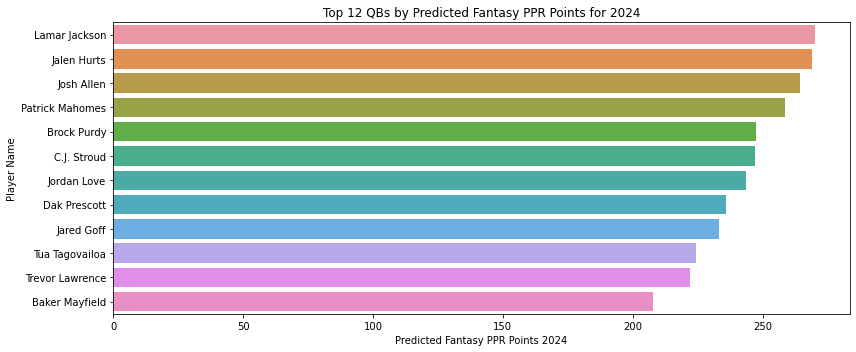

In [56]:
#predict QBs on the validation data using the best model and features found
#will get 2024 predictions in terms of points and position rank
#compare the predictions versus real 2024 point and rank

QB_2024_pred = predict_2024(QB_best_model, QB_best_features, QB_data_2024) #predictions of validation data
QB_metrics_table = pd.DataFrame([metric_table('QB', QB_data_2024, QB_2024_pred, fantasy_data_2024, "Fantasy_PPR_NextYear")]) #get RMSE, MAE, R2 of predictions versus real results
QB_2024_table = position_prediciton_table("QB", QB_data_2024, QB_2024_pred, fantasy_data_2024, "Name", "Team_NextYear", "Position", "Fantasy_PPR_NextYear") #display QB results

print(QB_metrics_table)
display(QB_2024_table)

plot_top12_position(QB_2024_table, position = "QB", title = "Top 12 QBs by Predicted Fantasy PPR Points for 2024")

### RB Model Tuning and Prediction

In [13]:
#figure out the best model with hyperparamter combinations and feature selections that give the lowest rmse for predicting RBs on training data
RB_results = [] #store model results

for name, (base_model, param_grid) in model_pipeline.items(): #iterate through model pipeline and each model's hyperparamter combinations
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy = "median")), #impute missing values using median
        ("scaler", StandardScaler()), #standardize features
        ("model", base_model) #model being fed through
        ])
    
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = rmse_scorer, cv = 3, n_jobs = -1) #3 fold cross validation will find best hyperparamters for each model, uses rmse as metric
    grid.fit(X_train_RB, y_train_RB) #fits grid search on RB training data

    best_model = grid.best_estimator_ #best model with best hyperparameters
    best_parameters = grid.best_params_ #gets best hyperparamter combination


    best_features, test_rmse = backward_feature_elimination(best_model, X_train_RB, y_train_RB, X_test_RB, y_test_RB) #do backwards feature selection on best model

    RB_results.append({ #build results table
        "Model": name, 
        "Best Parameters": best_parameters,
        "Selected Features": len(best_features),
        "Test_rmse": test_rmse})
    
    
RB_results_df = pd.DataFrame(RB_results).sort_values("Test_rmse") #converts to dataframe to sort by lowest rmse
RB_results_df

/Users/bunch/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


,Model,Best Parameters,Selected Features,Test_rmse
2,Neural Network,"{'model__alpha': 0.001, 'model__hidden_layer_s...",22,60.658188
4,XGBoost,"{'model__colsample_bytree': 0.8, 'model__learn...",21,61.511702
1,Lasso,{'model__alpha': 10},21,62.320658
0,Random Forest,"{'model__max_depth': 5, 'model__min_samples_sp...",18,63.011304
3,Support Vector Regression,"{'model__C': 0.1, 'model__gamma': 'scale', 'mo...",19,67.972782


In [14]:
#get RB fantasy projections for our testing data and compare them to the player's actual points scored in their next season
#projections will be on best model found for RBs (Neural Network)

best_model = grid.best_estimator_ #get best model found above

best_features, test_rmse = backward_feature_elimination(best_model, X_train_RB, y_train_RB, X_test_RB, y_test_RB) #do the backwards feature selection again on best model

best_model.fit(X_train_RB[best_features], y_train_RB) #fit the model onto the RB training data

y_pred_RB = best_model.predict(X_test_RB[best_features]) #predict RB fantasy points using best model


RB_test_results = pd.DataFrame({ #build results table comparing predicted vs actual fantasy points
    "Actual_Points": y_test_RB,
    "Predicted_Points": y_pred_RB
}, index = X_test_RB.index)

RB_best_model = best_model #save later for validation data
RB_best_features = best_features #save later for validation data

RB_test_results = fantasy_data.loc[RB_test_results.index, ["Name", "Team", "Position"]].join(RB_test_results)
RB_test_results

,Name,Team,Position,Actual_Points,Predicted_Points
232,Brandon Bolden,NWE,RB,124.1,38.820644
608,Wayne Gallman,NYG,RB,13.5,83.586288
497,Trayveon Williams,CIN,RB,21.7,32.380714
1145,Rashaad Penny,SEA,RB,52.2,113.300812
241,Dare Ogunbowale,TAM,RB,29.9,61.072079
...,...,...,...,...,...
35,Josh Jacobs,OAK,RB,231.3,132.771240
648,Zack Moss,BUF,RB,105.2,91.234634
1110,AJ Dillon,GNB,RB,167.6,145.138885
360,Derek Watt,LAC,RB,0.0,26.684938


  Position  RMSE Points  MAE Points  R2 Points  MAE Ranks
0       RB    69.965786   51.998128   0.479905  17.542857


,Name,Team,Position,Predicted Fantasy PPR Points 2024,Actual Fantasy PPR Points 2024,Predicted Position Rank,Actual Position Rank
0,Kyren Williams,LAR,RB,200.780273,272.1,1,7
1,Christian McCaffrey,SFO,RB,195.490326,47.8,2,62
2,Jahmyr Gibbs,DET,RB,194.769135,362.9,3,1
3,Travis Etienne,JAX,RB,194.437759,130.2,4,33
4,Joe Mixon,HOU,RB,191.494446,240.5,5,16
...,...,...,...,...,...,...,...
100,Jordan Mims,NOR,RB,26.771778,26.1,101,80
101,Jonathan Ward,PIT,RB,26.717636,2.2,102,96
102,Travis Homer,CHI,RB,26.468454,6.4,103,93
103,Jeremy McNichols,WAS,RB,26.269390,63.8,104,54


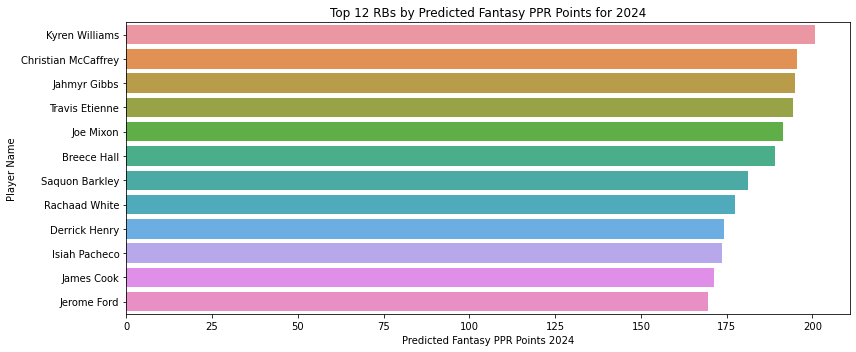

In [57]:
#predict RBs on the validation data using the best model and features found
#will get 2024 predictions in terms of points and position rank
#compare the predictions versus real 2024 point and rank

RB_2024_pred = predict_2024(RB_best_model, RB_best_features, RB_data_2024) #predictions of validation data
RB_metrics_table = pd.DataFrame([metric_table('RB', RB_data_2024, RB_2024_pred, fantasy_data_2024, "Fantasy_PPR_NextYear")]) #get RMSE, MAE, R2 of predictions versus real results
RB_2024_table = position_prediciton_table("RB", RB_data_2024, RB_2024_pred, fantasy_data_2024, "Name", "Team_NextYear", "Position", "Fantasy_PPR_NextYear") #display RB results

print(RB_metrics_table)
display(RB_2024_table)

plot_top12_position(RB_2024_table, position = "RB", title = "Top 12 RBs by Predicted Fantasy PPR Points for 2024")

### WR Model Tuning and Prediction

In [16]:
#figure out the best model with hyperparamter combinations and feature selections that give the lowest rmse for predicting WRs on training data
WR_results = [] #store model results

for name, (base_model, param_grid) in model_pipeline.items(): #iterate through model pipeline and each model's hyperparamter combinations
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy = "median")), #impute missing values using median
        ("scaler", StandardScaler()), #standardize features
        ("model", base_model) #model being fed through
        ])
    
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = rmse_scorer, cv = 3, n_jobs = -1) #3 fold cross validation will find best hyperparamters for each model, uses rmse as metric
    grid.fit(X_train_WR, y_train_WR) #fits grid search on WR training data

    best_model = grid.best_estimator_ #best model with best hyperparameters
    best_parameters = grid.best_params_ #gets best hyperparamter combination

    best_features, test_rmse = backward_feature_elimination(best_model, X_train_WR, y_train_WR, X_test_WR, y_test_WR) #do backwards feature selection on best model

    WR_results.append({ #build results table
        "Model": name, 
        "Best Parameters": best_parameters,
        "Selected Features": len(best_features),
        "Test_rmse": test_rmse})
    
WR_results_df = pd.DataFrame(WR_results).sort_values("Test_rmse") #converts to dataframe to sort by lowest rmse
WR_results_df

/Users/bunch/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


,Model,Best Parameters,Selected Features,Test_rmse
0,Random Forest,"{'model__max_depth': 5, 'model__min_samples_sp...",22,54.155282
4,XGBoost,"{'model__colsample_bytree': 0.5, 'model__learn...",22,54.276964
1,Lasso,{'model__alpha': 1},22,55.162495
3,Support Vector Regression,"{'model__C': 1, 'model__gamma': 'scale', 'mode...",22,55.827516
2,Neural Network,"{'model__alpha': 0.01, 'model__hidden_layer_si...",22,57.625581


In [17]:
#get WR fantasy projections for our testing data and compare them to the player's actual points scored in their next season
#projections will be on best model found for WRs (Random Forest)

best_model = grid.best_estimator_ #get best model found above

best_features, test_rmse = backward_feature_elimination(best_model, X_train_WR, y_train_WR, X_test_WR, y_test_WR) #do the backwards feature selection again on best model

best_model.fit(X_train_WR[best_features], y_train_WR) #fit the model onto the WR training data

y_pred_WR = best_model.predict(X_test_WR[best_features]) #predict WR fantasy points using best model


WR_test_results = pd.DataFrame({ #build results table comparing predicted vs actual fantasy points
    "Actual_Points": y_test_WR,
    "Predicted_Points": y_pred_WR
}, index = X_test_WR.index)

WR_best_model = best_model #save for validation later
WR_best_features = best_features #save for validation later

WR_test_results = fantasy_data.loc[WR_test_results.index, ["Name", "Team", "Position"]].join(WR_test_results)
WR_test_results

,Name,Team,Position,Actual_Points,Predicted_Points
421,Chris Moore,BAL,WR,0.0,17.911024
481,Jaydon Mickens,TAM,WR,12.8,19.956354
1545,Mason Kinsey,TEN,WR,1.3,21.787033
1748,Josh Reynolds,DET,WR,128.8,71.364517
1509,Kirk Merritt,MIA,WR,0.0,19.080769
...,...,...,...,...,...
974,Keith Kirkwood,CAR,WR,4.7,18.541893
1035,DeAndre Carter,2TM,WR,86.5,16.441494
685,Damiere Byrd,NWE,WR,64.9,96.674065
1510,Stanley Morgan Jr.,CIN,WR,0.0,19.291309


  Position  RMSE Points  MAE Points  R2 Points  MAE Ranks
0       WR     54.37794   40.937869    0.59237  29.336957


,Name,Team,Position,Predicted Fantasy PPR Points 2024,Actual Fantasy PPR Points 2024,Predicted Position Rank,Actual Position Rank
0,Amon-Ra St. Brown,DET,WR,270.381775,316.2,1,3
1,Puka Nacua,LAR,WR,258.188263,206.6,2,23
2,A.J. Brown,PHI,WR,253.944641,216.9,3,17
3,Tyreek Hill,MIA,WR,238.686554,218.2,4,15
4,CeeDee Lamb,DAL,WR,235.216202,263.4,5,6
...,...,...,...,...,...,...,...
179,Collin Johnson,CHI,WR,16.065010,1.6,180,161
180,Zach Pascal,ARI,WR,15.370488,0.0,181,181
181,Trent Taylor,SFO,WR,15.336282,2.1,182,158
182,Irvin Charles,NYJ,WR,14.051081,0.0,183,182


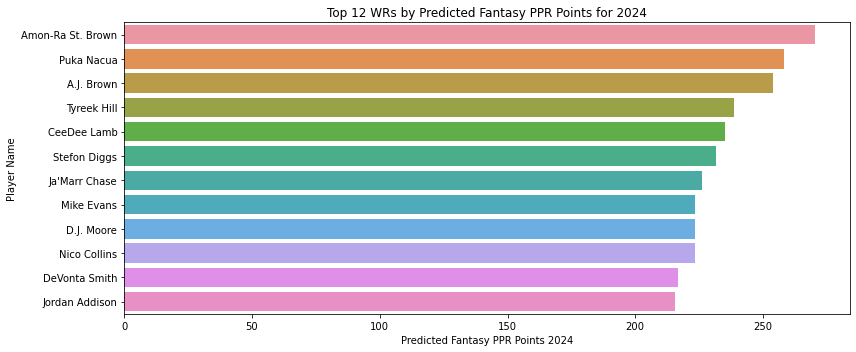

In [58]:
#predict WRs on the validation data using the best model and features found
#will get 2024 predictions in terms of points and position rank
#compare the predictions versus real 2024 point and rank

WR_2024_pred = predict_2024(WR_best_model, WR_best_features, WR_data_2024) #predictions of validation data
WR_metrics_table = pd.DataFrame([metric_table('WR', WR_data_2024, WR_2024_pred, fantasy_data_2024, "Fantasy_PPR_NextYear")]) #get RMSE, MAE, R2 of predictions versus real results
WR_2024_table = position_prediciton_table("WR", WR_data_2024, WR_2024_pred, fantasy_data_2024, "Name", "Team_NextYear", "Position", "Fantasy_PPR_NextYear") #display WR results

print(WR_metrics_table)
display(WR_2024_table)

plot_top12_position(WR_2024_table, position = "WR", title = "Top 12 WRs by Predicted Fantasy PPR Points for 2024")

### TE Model Tuning and Prediction

In [19]:
#figure out the best model with hyperparamter combinations and feature selections that give the lowest rmse for predicting TEs on training data
TE_results = [] #store model results

for name, (base_model, param_grid) in model_pipeline.items(): #iterate through model pipeline and each model's hyperparamter combinations
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy = "median")), #impute missing values using median
        ("scaler", StandardScaler()), #standardize features
        ("model", base_model) #model being fed through
        ])
    
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = rmse_scorer, cv = 3, n_jobs = -1) #3 fold cross validation will find best hyperparamters for each model, uses rmse as metric
    grid.fit(X_train_TE, y_train_TE) #fits grid search on TE training data

    best_model = grid.best_estimator_ #best model with best hyperparameters
    best_parameters = grid.best_params_ #gets best hyperparamter combination

    best_features, test_rmse = backward_feature_elimination(best_model, X_train_TE, y_train_TE, X_test_TE, y_test_TE)  #do backwards feature selection on best model

    TE_results.append({ #build results table
        "Model": name, 
        "Best Parameters": best_parameters,
        "Selected Features": len(best_features),
        "Test_rmse": test_rmse})
        
    
TE_results_df = pd.DataFrame(TE_results).sort_values("Test_rmse") #converts to dataframe to sort by lowest rmse
TE_results_df

/Users/bunch/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


,Model,Best Parameters,Selected Features,Test_rmse
4,XGBoost,"{'model__colsample_bytree': 0.5, 'model__learn...",21,39.092130
0,Random Forest,"{'model__max_depth': 5, 'model__min_samples_sp...",21,40.084302
1,Lasso,{'model__alpha': 1},21,41.346350
3,Support Vector Regression,"{'model__C': 1, 'model__gamma': 'scale', 'mode...",21,42.733986
2,Neural Network,"{'model__alpha': 0.01, 'model__hidden_layer_si...",22,43.320096


In [20]:
#get TE fantasy projections for our testing data and compare them to the player's actual points scored in their next season
#projections will be on best model found for TEs (XGBoost)

best_model = grid.best_estimator_ #get best model found above

best_features, test_rmse = backward_feature_elimination(best_model, X_train_TE, y_train_TE, X_test_TE, y_test_TE) #do the backwards feature selection again on best model

best_model.fit(X_train_TE[best_features], y_train_TE) #fit the model onto the TE training data

y_pred_TE = best_model.predict(X_test_TE[best_features]) #predict TE fantasy points using best model


TE_test_results = pd.DataFrame({ #build results table comparing predicted vs actual fantasy points
    "Actual_Points": y_test_TE,
    "Predicted_Points": y_pred_TE
}, index = X_test_TE.index)

TE_best_model = best_model #save for validation later
TE_best_features = best_features #save for validation later

TE_test_results = fantasy_data.loc[TE_test_results.index, ["Name", "Team", "Position"]].join(TE_test_results)
TE_test_results

,Name,Team,Position,Actual_Points,Predicted_Points
1390,Jesper Horsted,CHI,TE,4.9,15.104946
1956,Andrew Beck,DEN,TE,38.8,22.626835
2047,J.P. Holtz,NOR,TE,0.0,9.590635
1645,Dawson Knox,BUF,TE,54.6,103.407249
755,Cameron Brate,TAM,TE,78.5,45.615265
...,...,...,...,...,...
674,Dallas Goedert,PHI,TE,165.0,123.464188
1298,Josiah Deguara,GNB,TE,24.4,51.450897
220,Foster Moreau,OAK,TE,33.0,48.093697
1440,Luke Farrell,JAX,TE,8.0,22.591957


  Position  RMSE Points  MAE Points  R2 Points  MAE Ranks
0       TE     41.68631   29.585584   0.529208   17.72973


,Name,Team,Position,Predicted Fantasy PPR Points 2024,Actual Fantasy PPR Points 2024,Predicted Position Rank,Actual Position Rank
0,Evan Engram,JAX,TE,210.266785,89.5,1,32
1,Travis Kelce,KAN,TE,194.576828,195.4,2,4
2,T.J. Hockenson,MIN,TE,182.782654,86.5,3,33
3,Sam LaPorta,DET,TE,176.906921,174.6,4,7
4,David Njoku,CLE,TE,168.189606,148.5,5,10
...,...,...,...,...,...,...,...
106,Hunter Long,LAR,TE,10.931074,13.0,107,73
107,Anthony Firkser,2TM,TE,10.904464,0.0,108,109
108,Parker Hesse,DET,TE,10.829773,0.0,109,110
109,Brayden Willis,SFO,TE,10.820110,0.0,110,111


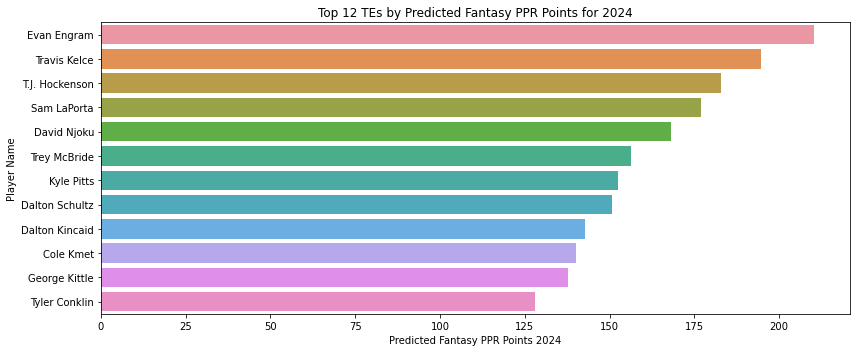

In [59]:
#predict TEs on the validation data using the best model and features found
#will get 2024 predictions in terms of points and position rank
#compare the predictions versus real 2024 point and rank

TE_2024_pred = predict_2024(TE_best_model, TE_best_features, TE_data_2024) #predictions of validation data
TE_metrics_table = pd.DataFrame([metric_table('TE', TE_data_2024, TE_2024_pred, fantasy_data_2024, "Fantasy_PPR_NextYear")]) #get RMSE, MAE, R2 of predictions versus real results
TE_2024_table = position_prediciton_table("TE", TE_data_2024, TE_2024_pred, fantasy_data_2024, "Name", "Team_NextYear", "Position", "Fantasy_PPR_NextYear") #display TE results

print(TE_metrics_table)
display(TE_2024_table)

plot_top12_position(TE_2024_table, position = "TE", title = "Top 12 TEs by Predicted Fantasy PPR Points for 2024")

### Combined Positional Predicitons

  Position  RMSE Points  MAE Points  R2 Points  MAE Ranks
0       QB    89.614877   68.691113   0.439528  12.875000
1       RB    69.965786   51.998128   0.479905  17.542857
2       WR    54.377940   40.937869   0.592370  29.336957
3       TE    41.686310   29.585584   0.529208  17.729730


,Name,Team,Position,Predicted Fantasy PPR Points 2024,Actual Fantasy PPR Points 2024,Predicted Overall Rank,Actual Overall Rank
0,Amon-Ra St. Brown,DET,WR,270.381775,316.2,1,12
1,Lamar Jackson,BAL,QB,269.975159,430.4,2,1
2,Jalen Hurts,PHI,QB,268.947906,315.1,3,13
3,Josh Allen,BUF,QB,264.428711,379.0,4,3
4,Patrick Mahomes,KAN,QB,258.454834,283.0,5,19
...,...,...,...,...,...,...,...
459,Hunter Long,LAR,TE,10.931074,13.0,460,342
460,Anthony Firkser,2TM,TE,10.904464,0.0,461,455
461,Parker Hesse,DET,TE,10.829773,0.0,462,456
462,Brayden Willis,SFO,TE,10.820110,0.0,463,457


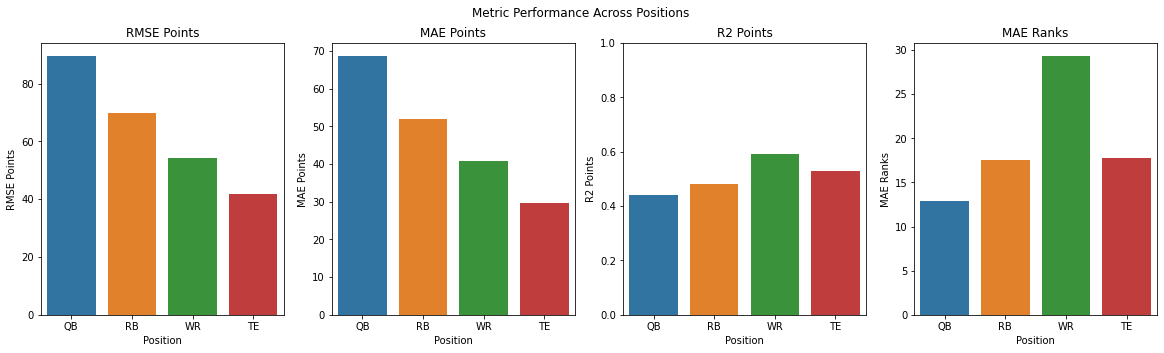

In [70]:
#combine all the individual position prediction tables into one encompassing table of overall predictions and rankings

combined_metrics_table = pd.concat([QB_metrics_table, RB_metrics_table, WR_metrics_table, TE_metrics_table], ignore_index = True) #combine all the metrics across all positions into one view
print(combined_metrics_table)

combined_results_2024 = overall_prediction_table(QB_2024_table, RB_2024_table, WR_2024_table, TE_2024_table) #combine all the predicitons (points and rank) and actual results (points and rank) across all positions into one view
display(combined_results_2024)

plot_positional_metric_comparison(combined_metrics_table)

## Part 3: Novelty Implementation

### Data Wrangling for NFL Rookie Fantasy Football Prediction

In [23]:
#get data for training/testing and validation
#make X and y for training/testing data

path = "training/final_rookie_data.csv" #final NFL rookie player dataset
rookie_data = pd.read_csv(path)

rookie_data_2024 = rookie_data[rookie_data["Draft_Year"] == 2024] #we are predicting 2024 rookies, this is our unseen validation data
rookie_data = rookie_data[rookie_data["Draft_Year"] != 2024] #years 2020-2023 as training and testing data

target_col = "Target" #what we are trying to predict
dropped_cols = {target_col, "Player", "Draft_Year", "Pos", "Team", "College", "Conf"} #dropping categorical features

#validation data (2024 rookies) for the four positions of interest outlined in our paper
rookie_QB_data_2024 = rookie_data_2024[rookie_data_2024["Pos"] == "QB"].drop(columns = dropped_cols) #rookie QB validation
rookie_RB_data_2024 = rookie_data_2024[rookie_data_2024["Pos"] == "RB"].drop(columns = dropped_cols) #rookie RB validation
rookie_WR_data_2024 = rookie_data_2024[rookie_data_2024["Pos"] == "WR"].drop(columns = dropped_cols) #rookie WR validation
rookie_TE_data_2024 = rookie_data_2024[rookie_data_2024["Pos"] == "TE"].drop(columns = dropped_cols) #rookie TE validation

#X and y for the four positions outlined in our paper 
rookie_QB_data = rookie_data[rookie_data["Pos"] == "QB"].drop(columns = dropped_cols) #input (X) data for rookie QB prediction
rookie_RB_data = rookie_data[rookie_data["Pos"] == "RB"].drop(columns = dropped_cols) #input (X) data for rookie RB prediction
rookie_WR_data = rookie_data[rookie_data["Pos"] == "WR"].drop(columns = dropped_cols) #input (X) data for rookie WR prediction
rookie_TE_data = rookie_data[rookie_data["Pos"] == "TE"].drop(columns = dropped_cols) #input (X) data for rookie TE prediction

rookie_QB_y = rookie_data.loc[rookie_QB_data.index, target_col] #target values for rookie QBs
rookie_RB_y = rookie_data.loc[rookie_RB_data.index, target_col] #target values for rookie RBs
rookie_WR_y = rookie_data.loc[rookie_WR_data.index, target_col] #target values for rookie WRs
rookie_TE_y = rookie_data.loc[rookie_TE_data.index, target_col] #target values for rookie TEs

In [24]:
#rookie train/test validation splits for the four positions

X_train_RQB, X_test_RQB, y_train_RQB, y_test_RQB = train_test_split(rookie_QB_data, rookie_QB_y, test_size = 0.20, random_state = 4) #rookie QB training and testing data

X_train_RRB, X_test_RRB, y_train_RRB, y_test_RRB = train_test_split(rookie_RB_data, rookie_RB_y, test_size = 0.20, random_state = 4) #rookie RB training and testing data

X_train_RWR, X_test_RWR, y_train_RWR, y_test_RWR = train_test_split(rookie_WR_data, rookie_WR_y, test_size = 0.20, random_state = 4) #rookie WR training and testing data

X_train_RTE, X_test_RTE, y_train_RTE, y_test_RTE = train_test_split(rookie_TE_data, rookie_TE_y, test_size = 0.20, random_state = 4) #rookie TE training and testing data

### Rookie QB Model Tuning and Prediction

In [25]:
#figure out the best model with hyperparamter combinations and feature selections that give the lowest rmse for predicting rookie QBs on training data
rookie_QB_results = [] #store model results

for name, (base_model, param_grid) in model_pipeline.items(): #iterate through model pipeline and each model's hyperparamter combinations
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy = "median")), #impute missing values using median
        ("scaler", StandardScaler()), #standardize features
        ("model", base_model) #model being fed through
        ])
    
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = rmse_scorer, cv = 3, n_jobs = -1) #3 fold cross validation will find best hyperparamters for each model, uses rmse as metric
    grid.fit(X_train_RQB, y_train_RQB) #fits grid search onto the rookie QB training data

    best_model = grid.best_estimator_ #best model with best hyperparameters
    best_parameters = grid.best_params_ #gets best hyperparamter combination

    best_features, test_rmse = backward_feature_elimination(best_model, X_train_RQB, y_train_RQB, X_test_RQB, y_test_RQB) #do backwards feature selection on best model

    rookie_QB_results.append({ #build results table
        "Model": name, 
        "Best Parameters": best_parameters,
        "Selected Features": len(best_features),
        "Test_rmse": test_rmse})
    
rookie_QB_results_df = pd.DataFrame(rookie_QB_results).sort_values("Test_rmse") #converts to dataframe to sort by lowest rmse
rookie_QB_results_df

/Users/bunch/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


,Model,Best Parameters,Selected Features,Test_rmse
4,XGBoost,"{'model__colsample_bytree': 1, 'model__learnin...",10,68.801959
2,Neural Network,"{'model__alpha': 0.001, 'model__hidden_layer_s...",19,69.029079
0,Random Forest,"{'model__max_depth': 10, 'model__min_samples_s...",18,70.041348
1,Lasso,{'model__alpha': 10},9,71.770939
3,Support Vector Regression,"{'model__C': 1, 'model__gamma': 'scale', 'mode...",15,73.722974


In [26]:
#get rookie QB fantasy projections for our testing data and compare them to the player's actual points scored in their rookie season
#projections will be on best model found for QBs (XGBoost)

best_model = grid.best_estimator_ #get best model found above

best_features, test_rmse = backward_feature_elimination(best_model, X_train_RQB, y_train_RQB, X_test_RQB, y_test_RQB) #do the backwards feature selection again on best model

best_model.fit(X_train_RQB[best_features], y_train_RQB) #fit the model onto the rookie QB training data

y_pred_RQB = best_model.predict(X_test_RQB[best_features]) #predict rookie QB fantasy points using best model


rookie_QB_test_results = pd.DataFrame({ #build results table comparing predicted vs actual fantasy points
    "Actual_Points": y_test_RQB,
    "Predicted_Points": y_pred_RQB
}, index = X_test_RQB.index)

rookie_QB_best_model = best_model #save later for validation data
rookie_QB_best_features = best_features #save later for validation data

rookie_QB_test_results = rookie_data.loc[rookie_QB_test_results.index, ["Player", "Team", "Pos"]].join(rookie_QB_test_results)
rookie_QB_test_results

,Player,Team,Pos,Actual_Points,Predicted_Points
223,Anthony Richardson,IND,QB,72.7,159.091537
293,Max Duggan,LAC,QB,0.0,14.828439
20,Jalen Hurts,PHI,QB,109.1,64.673103
82,Mac Jones,NWE,QB,224.9,150.922424
220,Brock Purdy,SFO,QB,106.3,3.880309
116,Ian Book,NOR,QB,2.0,2.585561
94,Kyle Trask,TAM,QB,0.0,52.932411
51,Jake Fromm,BUF,QB,0.0,21.796417
96,Davis Mills,HOU,QB,157.0,39.925175


  Position  RMSE Points  MAE Points  R2 Points  MAE Ranks
0       QB   108.596973     78.7523   0.322525   2.363636


,Name,Team,Position,Predicted Fantasy PPR Points 2024,Actual Fantasy PPR Points 2024,Predicted Position Rank,Actual Position Rank
0,J.J. McCarthy,MIN,QB,202.007248,0.0,1,8
1,Michael Penix,ATL,QB,197.494247,44.1,2,6
2,Bo Nix,DEN,QB,175.824066,317.2,3,2
3,Jayden Daniels,WAS,QB,173.371628,355.8,4,1
4,Drake Maye,NWE,QB,168.466522,177.1,5,4
5,Caleb Williams,CHI,QB,161.702820,254.5,6,3
6,Joe Milton,NWE,QB,14.787249,19.2,7,7
7,Devin Leary,BAL,QB,13.724623,0.0,8,9
8,Spencer Rattler,NOR,QB,11.098861,67.3,9,5
9,Jordan Travis,NYJ,QB,7.415210,0.0,10,10


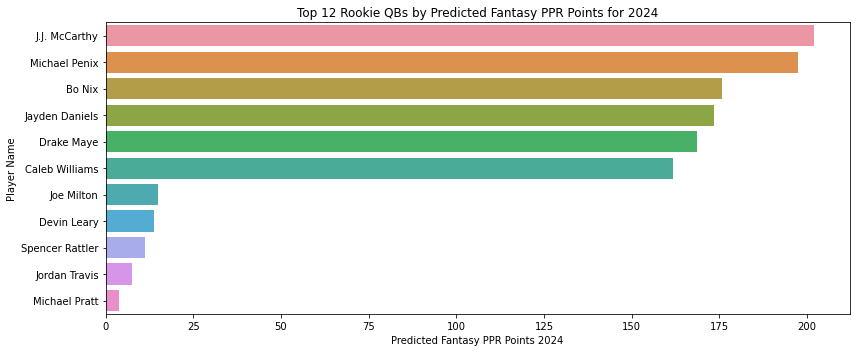

In [60]:
#predict rookie QBs on the validation data using the best model and features found
#will get 2024 predictions in terms of points and position rank
#compare the predictions versus real 2024 point and rank

rookie_QB_2024_pred = predict_2024(rookie_QB_best_model, rookie_QB_best_features, rookie_QB_data_2024) #predictions of validation data
rookie_QB_metrics_table = pd.DataFrame([metric_table('QB', rookie_QB_data_2024, rookie_QB_2024_pred, rookie_data_2024, "Target")]) #get RMSE, MAE, R2 of predictions versus real results
rookie_QB_2024_table = position_prediciton_table("QB", rookie_QB_data_2024, rookie_QB_2024_pred, rookie_data_2024, "Player", "Team", "Pos", "Target") #display rookie QB results

print(rookie_QB_metrics_table)
display(rookie_QB_2024_table)

plot_top12_position(rookie_QB_2024_table, position = "QB", title = "Top 12 Rookie QBs by Predicted Fantasy PPR Points for 2024")

### Rookie RB Model Tuning and Prediction

In [28]:
#figure out the best model with hyperparamter combinations and feature selections that give the lowest rmse for predicting rookie RBs on training data
rookie_RB_results = [] #store model results

for name, (base_model, param_grid) in model_pipeline.items(): #iterate through model pipeline and each model's hyperparamter combinations
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy = "median")), #impute missing values using median
        ("scaler", StandardScaler()), #standardize features
        ("model", base_model) #model being fed through
        ])
    
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = rmse_scorer, cv = 3, n_jobs = -1) #3 fold cross validation will find best hyperparamters for each model, uses rmse as metric
    grid.fit(X_train_RRB, y_train_RRB) #fits grid search on rookie RB training data

    best_model = grid.best_estimator_ #best model with best hyperparameters
    best_parameters = grid.best_params_ #gets best hyperparamter combination

    best_features, test_rmse = backward_feature_elimination(best_model, X_train_RRB, y_train_RRB, X_test_RRB, y_test_RRB) #do backwards feature selection on best model

    rookie_RB_results.append({ #build results table
        "Model": name, 
        "Best Parameters": best_parameters,
        "Selected Features": len(best_features),
        "Test_rmse": test_rmse})
    
rookie_RB_results_df = pd.DataFrame(rookie_RB_results).sort_values("Test_rmse") #converts to dataframe to sort by lowest rmse
rookie_RB_results_df

/Users/bunch/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.689e+02, tolerance: 2.504e+01
  model = cd_fast.enet_coordinate_descent(
/Users/bunch/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.506e+02, tolerance: 2.792e+01
  model = cd_fast.enet_coordinate_descent(
/Users/bunch/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is depreca

,Model,Best Parameters,Selected Features,Test_rmse
1,Lasso,{'model__alpha': 10},9,66.767806
2,Neural Network,"{'model__alpha': 0.01, 'model__hidden_layer_si...",19,72.676540
0,Random Forest,"{'model__max_depth': 10, 'model__min_samples_s...",18,76.099431
3,Support Vector Regression,"{'model__C': 10, 'model__gamma': 'auto', 'mode...",19,77.952413
4,XGBoost,"{'model__colsample_bytree': 0.8, 'model__learn...",17,82.273705


In [29]:
#get rookie RB fantasy projections for our testing data and compare them to the player's actual points scored in their rookie season
#projections will be on best model found for RBs (Lasso)

best_model = grid.best_estimator_ #get best model found above

best_features, test_rmse = backward_feature_elimination(best_model, X_train_RRB, y_train_RRB, X_test_RRB, y_test_RRB) #do the backwards feature selection again on best model

best_model.fit(X_train_RRB[best_features], y_train_RRB) #fit the model onto the rookie RB training data

y_pred_RRB = best_model.predict(X_test_RRB[best_features]) #predict rookie RB fantasy points using best model


rookie_RB_test_results = pd.DataFrame({ #build results table comparing predicted vs actual fantasy points
    "Actual_Points": y_test_RRB,
    "Predicted_Points": y_pred_RRB
}, index = X_test_RRB.index)

rookie_RB_best_model = best_model #save later for validation data
rookie_RB_best_features = best_features #save later for validation data

rookie_RB_test_results = rookie_data.loc[rookie_RB_test_results.index, ["Player", "Team", "Pos"]].join(rookie_RB_test_results)
rookie_RB_test_results

,Player,Team,Pos,Actual_Points,Predicted_Points
197,Jerome Ford,CLE,RB,1.2,34.162884
255,Roschon Johnson,CHI,RB,102.1,75.365356
225,Jahmyr Gibbs,DET,RB,242.1,188.398132
196,Snoop Conner,JAX,RB,10.2,27.596960
53,Jason Huntley,DET,RB,2.9,24.811478
120,Kenny Gainwell,PHI,RB,0.0,22.364128
287,Zach Evans,LAR,RB,1.9,15.791488
110,Rhamondre Stevenson,NWE,RB,114.9,50.188850
129,Larry Rountree,LAC,RB,15.6,24.558384
21,J.K. Dobbins,BAL,RB,168.5,187.401123


  Position  RMSE Points  MAE Points  R2 Points  MAE Ranks
0       RB    86.007986   63.766977  -0.595824      5.875


,Name,Team,Position,Predicted Fantasy PPR Points 2024,Actual Fantasy PPR Points 2024,Predicted Position Rank,Actual Position Rank
0,Jonathon Brooks,CAR,RB,179.617310,7.5,1,11
1,Trey Benson,ARI,RB,115.113235,47.0,2,6
2,Blake Corum,LAR,RB,99.754662,33.5,3,7
3,Rasheen Ali,BAL,RB,80.353096,3.1,4,13
4,MarShawn Lloyd,GNB,RB,76.469376,2.8,5,14
5,Jaylen Wright,MIA,RB,56.097847,26.7,6,9
6,Tyrone Tracy Jr.,NYG,RB,55.185802,182.3,7,2
7,Keilan Robinson,JAX,RB,51.958641,0.0,8,15
8,Isaac Guerendo,SFO,RB,50.446320,94.2,9,3
9,Braelon Allen,NYJ,RB,48.547054,85.2,10,4


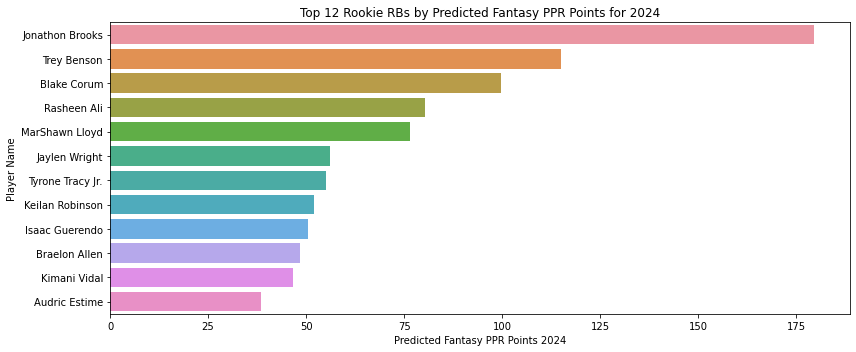

In [61]:
#predict rookie RBs on the validation data using the best model and features found
#will get 2024 predictions in terms of points and position rank
#compare the predictions versus real 2024 point and rank

rookie_RB_2024_pred = predict_2024(rookie_RB_best_model, rookie_RB_best_features, rookie_RB_data_2024) #predictions of validation data
rookie_RB_metrics_table = pd.DataFrame([metric_table('RB', rookie_RB_data_2024, rookie_RB_2024_pred, rookie_data_2024, "Target")]) #get RMSE, MAE, R2 of predictions versus real results
rookie_RB_2024_table = position_prediciton_table("RB", rookie_RB_data_2024, rookie_RB_2024_pred, rookie_data_2024, "Player", "Team", "Pos", "Target") #display rookie RB results

print(rookie_RB_metrics_table)
display(rookie_RB_2024_table)

plot_top12_position(rookie_RB_2024_table, position = "RB", title = "Top 12 Rookie RBs by Predicted Fantasy PPR Points for 2024")

### Rookie WR Model Tuning and Prediction

In [31]:
#figure out the best model with hyperparamter combinations and feature selections that give the lowest rmse for predicting rookie WRs on training data
rookie_WR_results = [] #store model results

for name, (base_model, param_grid) in model_pipeline.items(): #iterate through model pipeline and each model's hyperparamter combinations
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy = "median")), #impute missing values using median
        ("scaler", StandardScaler()), #standardize features
        ("model", base_model) #model being fed through
        ])
    
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = rmse_scorer, cv = 3, n_jobs = -1) #3 fold cross validation will find best hyperparamters for each model, uses rmse as metric
    grid.fit(X_train_RWR, y_train_RWR) #fits grid search on rookie WR training data

    best_model = grid.best_estimator_ #best model with best hyperparameters
    best_parameters = grid.best_params_ #gets best hyperparamter combination

    best_features, test_rmse = backward_feature_elimination(best_model, X_train_RWR, y_train_RWR, X_test_RWR, y_test_RWR) #do backwards feature selection on best model

    rookie_WR_results.append({ #build results table
        "Model": name, 
        "Best Parameters": best_parameters,
        "Selected Features": len(best_features),
        "Test_rmse": test_rmse})
    
rookie_WR_results_df = pd.DataFrame(rookie_WR_results).sort_values("Test_rmse")  #converts to dataframe to sort by lowest rmse
rookie_WR_results_df

/Users/bunch/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


,Model,Best Parameters,Selected Features,Test_rmse
4,XGBoost,"{'model__colsample_bytree': 0.5, 'model__learn...",18,77.383999
0,Random Forest,"{'model__max_depth': 5, 'model__min_samples_sp...",18,82.460115
1,Lasso,{'model__alpha': 10},5,83.106063
2,Neural Network,"{'model__alpha': 0.0001, 'model__hidden_layer_...",19,143.421906
3,Support Vector Regression,"{'model__C': 1, 'model__gamma': 'scale', 'mode...",18,183.645588


In [32]:
#get rookie WR fantasy projections for our testing data and compare them to the player's actual points scored in their rookie season
#projections will be on best model found for WRs (XGBoost)

best_model = grid.best_estimator_ #get best model found above

best_features, test_rmse = backward_feature_elimination(best_model, X_train_RWR, y_train_RWR, X_test_RWR, y_test_RWR) #do the backwards feature selection again on best model

best_model.fit(X_train_RWR[best_features], y_train_RWR) #fit the model onto the rookie WR training data

y_pred_RWR = best_model.predict(X_test_RWR[best_features]) #predict rookie WR fantasy points using best model


rookie_WR_test_results = pd.DataFrame({ #build results table comparing predicted vs actual fantasy points
    "Actual_Points": y_test_RWR,
    "Predicted_Points": y_pred_RWR
}, index = X_test_RWR.index)

rookie_WR_best_model = best_model #save for validation later
rookie_WR_best_features = best_features #save for validation later

rookie_WR_test_results = rookie_data.loc[rookie_WR_test_results.index, ["Player", "Team", "Pos"]].join(rookie_WR_test_results)
rookie_WR_test_results

,Player,Team,Pos,Actual_Points,Predicted_Points
49,Collin Johnson,JAX,WR,59.2,81.260796
170,Jalen Tolbert,DAL,WR,3.2,41.499283
141,Tre Nixon,NWE,WR,0.0,25.034122
42,Gabriel Davis,BUF,WR,136.9,41.485363
8,Brandon Aiyuk,SFO,WR,184.5,109.674828
177,Danny Gray,SFO,WR,2.9,31.490906
159,Tyquan Thornton,NWE,WR,66.3,94.325012
162,Skyy Moore,KAN,WR,43.4,77.110764
59,Quez Watkins,PHI,WR,23.6,33.333813
5,CeeDee Lamb,DAL,WR,217.7,112.721649


  Position  RMSE Points  MAE Points  R2 Points  MAE Ranks
0       WR    60.385889   45.765553   0.474048   5.529412


,Name,Team,Position,Predicted Fantasy PPR Points 2024,Actual Fantasy PPR Points 2024,Predicted Position Rank,Actual Position Rank
0,Marvin Harrison Jr.,ARI,WR,119.607193,196.5,1,4
1,Ladd McConkey,LAC,WR,119.520584,240.9,2,3
2,Brian Thomas,JAX,WR,114.657516,284.0,3,1
3,Xavier Legette,CAR,WR,113.379944,125.1,4,8
4,Xavier Worthy,KAN,WR,112.218010,187.2,5,5
5,Malik Nabers,NYG,WR,111.886421,273.6,6,2
6,Rome Odunze,CHI,WR,110.257538,144.9,7,6
7,Ja'Lynn Polk,NWE,WR,103.740990,32.7,8,17
8,Keon Coleman,BUF,WR,98.702461,111.5,9,9
9,Adonai Mitchell,IND,WR,96.672531,53.8,10,14


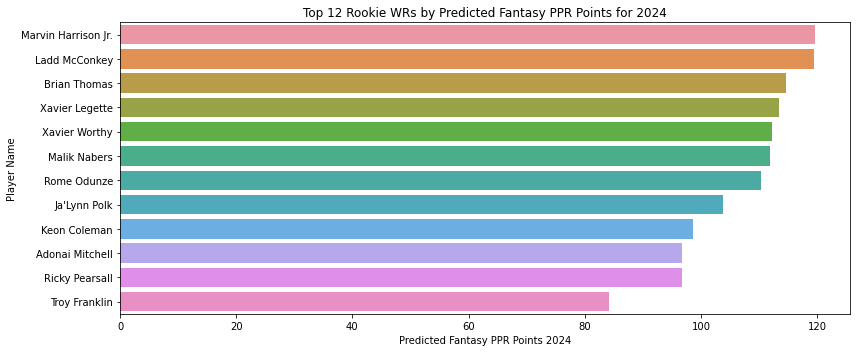

In [62]:
#predict rookie WRs on the validation data using the best model and features found
#will get 2024 predictions in terms of points and position rank
#compare the predictions versus real 2024 point and rank

rookie_WR_2024_pred = predict_2024(rookie_WR_best_model, rookie_WR_best_features, rookie_WR_data_2024) #predictions of validation data
rookie_WR_metrics_table = pd.DataFrame([metric_table('WR', rookie_WR_data_2024, rookie_WR_2024_pred, rookie_data_2024, "Target")]) #get RMSE, MAE, R2 of predictions versus real results
rookie_WR_2024_table = position_prediciton_table("WR", rookie_WR_data_2024, rookie_WR_2024_pred, rookie_data_2024, "Player", "Team", "Pos", "Target") #display rookie WR results

print(rookie_WR_metrics_table)
display(rookie_WR_2024_table)

plot_top12_position(rookie_WR_2024_table, position = "WR", title = "Top 12 Rookie WRs by Predicted Fantasy PPR Points for 2024")

### Rookie TE Model Tuning and Prediction

In [34]:
#figure out the best model with hyperparamter combinations and feature selections that give the lowest rmse for predicting rookie TEs on training data
rookie_TE_results = [] #store model results

for name, (base_model, param_grid) in model_pipeline.items(): #iterate through model pipeline and each model's hyperparamter combinations
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy = "median")), #impute missing values using median
        ("scaler", StandardScaler()), #standardize features
        ("model", base_model) #model being fed through
        ])
    
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring = rmse_scorer, cv = 3, n_jobs = -1) #3 fold cross validation will find best hyperparamters for each model, uses rmse as metric
    grid.fit(X_train_RTE, y_train_RTE) #fits grid search on rookie TE training data

    best_model = grid.best_estimator_ #best model with best hyperparameters
    best_parameters = grid.best_params_ #gets best hyperparamter combination

    best_features, test_rmse = backward_feature_elimination(best_model, X_train_RTE, y_train_RTE, X_test_RTE, y_test_RTE) #do backwards feature selection on best model

    rookie_TE_results.append({ #build results table
        "Model": name, 
        "Best Parameters": best_parameters,
        "Selected Features": len(best_features),
        "Test_rmse": test_rmse})
    
rookie_TE_results_df = pd.DataFrame(rookie_TE_results).sort_values("Test_rmse") #converts to dataframe to sort by lowest rmse
rookie_TE_results_df

/Users/bunch/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


,Model,Best Parameters,Selected Features,Test_rmse
2,Neural Network,"{'model__alpha': 0.01, 'model__hidden_layer_si...",19,33.441977
1,Lasso,{'model__alpha': 10},19,37.618749
3,Support Vector Regression,"{'model__C': 1, 'model__gamma': 'scale', 'mode...",16,40.748053
4,XGBoost,"{'model__colsample_bytree': 0.5, 'model__learn...",19,43.828741
0,Random Forest,"{'model__max_depth': 5, 'model__min_samples_sp...",19,45.387228


In [35]:
#get rookie TE fantasy projections for our testing data and compare them to the player's actual points scored in their rookie season
#projections will be on best model found for TEs (Neural Network)

best_model = grid.best_estimator_ #get best model found above

best_features, test_rmse = backward_feature_elimination(best_model, X_train_RTE, y_train_RTE, X_test_RTE, y_test_RTE) #do the backwards feature selection again on best model

best_model.fit(X_train_RTE[best_features], y_train_RTE) #fit the model onto the rookie TE training data

y_pred_RTE = best_model.predict(X_test_RTE[best_features]) #predict TE fantasy points using best model


rookie_TE_test_results = pd.DataFrame({ #build results table comparing predicted vs actual fantasy points
    "Actual_Points": y_test_RTE,
    "Predicted_Points": y_pred_RTE
}, index = X_test_RTE.index)

rookie_TE_best_model = best_model #save for validation later
rookie_TE_best_features = best_features #save for validation later

rookie_TE_test_results = rookie_data.loc[rookie_TE_test_results.index, ["Player", "Team", "Pos"]].join(rookie_TE_test_results)
rookie_TE_test_results

,Player,Team,Pos,Actual_Points,Predicted_Points
36,Harrison Bryant,CLE,TE,61.8,62.629902
122,Noah Gray,KAN,TE,16.6,53.566723
289,Zack Kuntz,NYJ,TE,0.0,37.838814
166,Jelani Woods,IND,TE,74.2,42.483250
90,Pat Freiermuth,PIT,TE,151.7,57.564983
194,Cole Turner,WAS,TE,4.3,58.217846
185,Jake Ferguson,DAL,TE,48.4,37.496292
212,Ko Kieft,TAM,TE,21.0,26.050419
43,Colby Parkinson,SEA,TE,3.6,52.940083
113,Kylen Granson,IND,TE,21.6,30.925142


  Position  RMSE Points  MAE Points  R2 Points  MAE Ranks
0       TE    52.954076   36.535485    0.42538   2.833333


,Name,Team,Position,Predicted Fantasy PPR Points 2024,Actual Fantasy PPR Points 2024,Predicted Position Rank,Actual Position Rank
0,Brock Bowers,LVR,TE,114.943810,262.7,1,1
1,Ben Sinnott,WAS,TE,71.444405,13.8,2,7
2,Ja'Tavion Sanders,CAR,TE,58.008095,73.2,3,3
3,Jared Wiley,KAN,TE,47.076683,1.7,4,11
4,Cade Stover,HOU,TE,30.037766,34.3,5,6
5,Erick All,CIN,TE,29.990170,35.8,6,5
6,Theo Johnson,NYG,TE,25.301426,68.1,7,4
7,Tip Reiman,ARI,TE,24.950983,9.7,8,9
8,Jaheim Bell,NWE,TE,24.018522,4.0,9,10
9,Tanner McLachlan,CIN,TE,23.342562,0.0,10,12


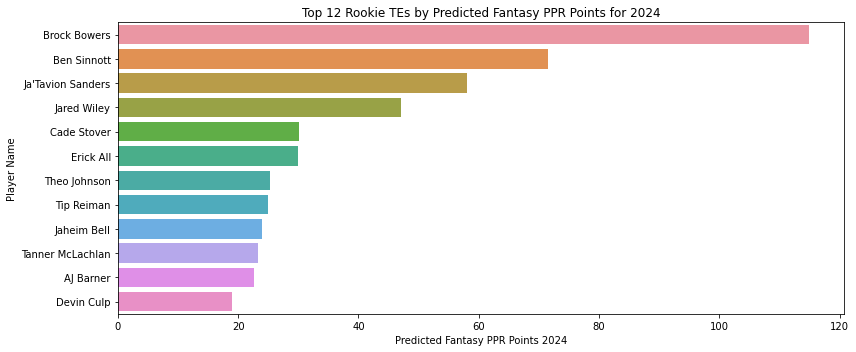

In [63]:
#predict rookie TEs on the validation data using the best model and features found
#will get 2024 predictions in terms of points and position rank
#compare the predictions versus real 2024 point and rank

rookie_TE_2024_pred = predict_2024(rookie_TE_best_model, rookie_TE_best_features, rookie_TE_data_2024) #predictions of validation data
rookie_TE_metrics_table = pd.DataFrame([metric_table('TE', rookie_TE_data_2024, rookie_TE_2024_pred, rookie_data_2024, "Target")]) #get RMSE, MAE, R2 of predictions versus real results
rookie_TE_2024_table = position_prediciton_table("TE", rookie_TE_data_2024, rookie_TE_2024_pred, rookie_data_2024, "Player", "Team", "Pos", "Target") #display rookie TE results

print(rookie_TE_metrics_table)
display(rookie_TE_2024_table)

plot_top12_position(rookie_TE_2024_table, position = "TE", title = "Top 12 Rookie TEs by Predicted Fantasy PPR Points for 2024")

### Combined Rookie Positional Predicitons

  Position  RMSE Points  MAE Points  R2 Points  MAE Ranks
0       QB   108.596973   78.752300   0.322525   2.363636
1       RB    86.007986   63.766977  -0.595824   5.875000
2       WR    60.385889   45.765553   0.474048   5.529412
3       TE    52.954076   36.535485   0.425380   2.833333


,Name,Team,Position,Predicted Fantasy PPR Points 2024,Actual Fantasy PPR Points 2024,Predicted Overall Rank,Actual Overall Rank
0,J.J. McCarthy,MIN,QB,202.007248,0.0,1,61
1,Michael Penix,ATL,QB,197.494247,44.1,2,31
2,Jonathon Brooks,CAR,RB,179.617310,7.5,3,50
3,Bo Nix,DEN,QB,175.824066,317.2,4,2
4,Jayden Daniels,WAS,QB,173.371628,355.8,5,1
...,...,...,...,...,...,...,...
68,Joe Milton,NWE,QB,14.787249,19.2,69,40
69,Devin Leary,BAL,QB,13.724623,0.0,70,70
70,Spencer Rattler,NOR,QB,11.098861,67.3,71,24
71,Jordan Travis,NYJ,QB,7.415210,0.0,72,71


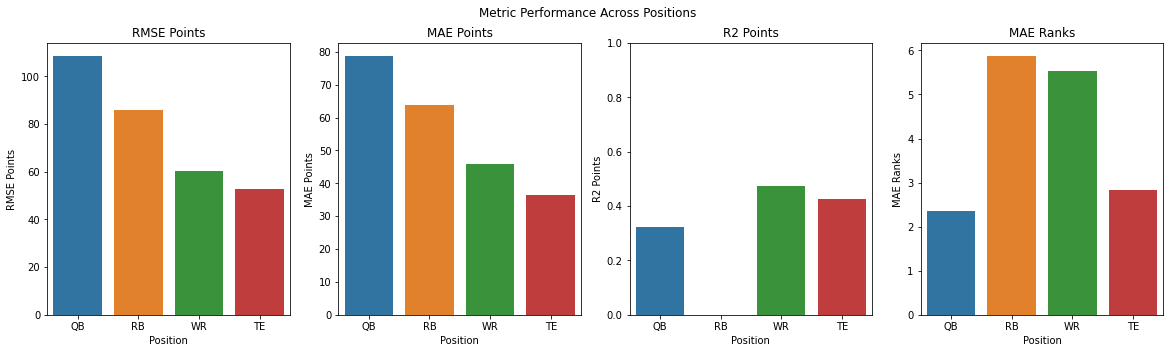

In [69]:
#combine all the individual rookie position prediction tables into one encompassing table of overall predictions and rankings

combined_rookie_metrics_table = pd.concat([rookie_QB_metrics_table, rookie_RB_metrics_table, rookie_WR_metrics_table, rookie_TE_metrics_table], ignore_index = True) #combine all the metrics across all positions into one view for rookies
print(combined_rookie_metrics_table)

combined_rookie_results_2024 = overall_prediction_table(rookie_QB_2024_table, rookie_RB_2024_table, rookie_WR_2024_table, rookie_TE_2024_table) #combine all the predicitons (points and rank) and actual results (points and rank) across all positions into one view for rookies
display(combined_rookie_results_2024)

plot_positional_metric_comparison(combined_rookie_metrics_table)